In [215]:
import json
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
import xml.etree.ElementTree as ET

In [216]:
main_dir = '/zhome/97/a/203937/02516_poster_3/'
img_dir = main_dir + 'Potholes/annotated-images/'
proposal_file_path = main_dir + 'labeled_proposals_edge_boxes.json'
split_file_path = main_dir + 'Potholes/splits.json'

# Make sure the above paths are correct
assert os.path.exists(main_dir), f"Main directory does not exist: {main_dir}"
assert os.path.exists(img_dir), f"Image directory does not exist: {img_dir}"
assert os.path.exists(proposal_file_path), f"Proposal file does not exist: {proposal_file_path}"
assert os.path.exists(split_file_path), f"Split file does not exist: {split_file_path}"
print("All paths are verified and exist.")

All paths are verified and exist.


In [217]:
with open(proposal_file_path, 'r') as f:
    proposals = json.load(f)

In [218]:
class PotholeDatasetFromProposals(Dataset):
    def __init__(self, image_file_list, img_dir, proposals, transform=None):
        self.image_file_list = image_file_list
        self.img_dir = img_dir
        self.proposals = proposals
        self.transform = transform
        self.new_size = next((t.size for t in transform.transforms if isinstance(t, T.Resize)), None)

    def __len__(self):
        return len(self.image_file_list)

    def __getitem__(self, idx):
        img_name = self.image_file_list[idx]
        image_path = os.path.join(self.img_dir, img_name)
        image = Image.open(image_path).convert("RGB")
        original_size = image.size

        scale_x, scale_y = (self.new_size[0] / original_size[0], self.new_size[1] / original_size[1]) if self.new_size else (1.0, 1.0)

        boxes, labels = self._get_proposals(img_name, scale_x, scale_y)

        if not boxes:  # No potholes found
            boxes, labels = self._add_from_xml(img_name, scale_x, scale_y)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int8)

        if self.transform:
            image = self.transform(image)

        return image, {'boxes': boxes, 'labels': labels}

    def _get_proposals(self, img_name, scale_x, scale_y):
        boxes, labels = [], []
        at_least_one_pothole = False

        for proposal in self.proposals.get(img_name, []):
            x_resized, y_resized = proposal["x"] * scale_x, proposal["y"] * scale_y
            width_resized, height_resized = proposal["width"] * scale_x, proposal["height"] * scale_y

            boxes.append([x_resized, y_resized, width_resized, height_resized])
            label = 1 if proposal['label'] == "pothole" else 0
            labels.append(label)

            if label == 1:
                at_least_one_pothole = True

        # Ensure that we return empty boxes and labels if no pothole was found
        return (boxes, labels) if at_least_one_pothole else ([], [])

    def _add_from_xml(self, img_name, scale_x, scale_y):
        xml_file = img_name.replace('.jpg', '.xml')
        tree = ET.parse(os.path.join(self.img_dir, xml_file))
        root = tree.getroot()

        boxes, labels = [], []
        for obj in root.findall("object"):
            if obj.find("name").text == "pothole":
                bbox = obj.find("bndbox")
                xmin, ymin, xmax, ymax = map(int, (bbox.find("xmin").text, bbox.find("ymin").text, bbox.find("xmax").text, bbox.find("ymax").text))
                width_resized, height_resized = (xmax - xmin) * scale_x, (ymax - ymin) * scale_y
                boxes.append([xmin * scale_x, ymin * scale_y, width_resized, height_resized])
                labels.append(1)

        return boxes, labels


In [219]:
image_file_list = list(proposals.keys())  # Image files in the proposals

# Define transformations
transform = T.Compose([
    T.Resize((720, 720)), # FOR NOW ALIGN WITH THE PROPOSALS, CHANGE DATALOADERS TO ALIGN WITH THE TRANSFORM
    T.ToTensor()
])

# Initialize dataset with only proposals
dataset = PotholeDatasetFromProposals(
    image_file_list=image_file_list,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

# Define DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# # Example loop to access batched data
# for images, targets in dataloader:
#     print("Batch of images:", images)
#     print("Batch of targets:", targets)
#     break  # Display only the first batch


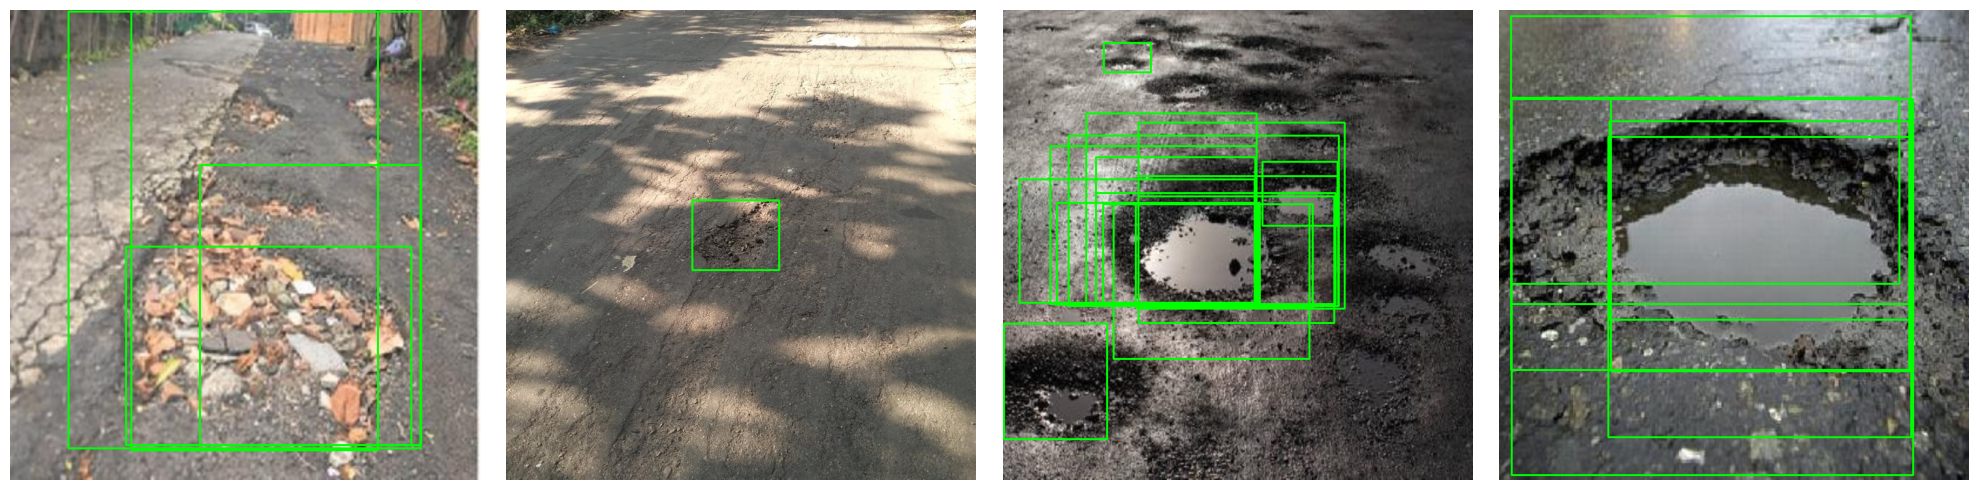

In [220]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def plot_images(images, targets, denormalize=False):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    
    for i, (image, target) in enumerate(zip(images, targets)):
        # Convert image to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C) and move to CPU if necessary
        if denormalize:
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean  # Denormalize
            image = np.clip(image, 0, 1)  # Clip to [0, 1] range for display
        
        image = (image * 255).astype(np.uint8)
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw bounding boxes on the BGR image
        for box, label in zip(target['boxes'], target['labels']):
            x, y, w, h = box.numpy().astype(int)
            
            color = (0, 0, 255) if label == 0 else (0, 255, 0)
            
            if label == 1:
                image_bgr = cv2.rectangle(image_bgr, (x, y), (x + w, y + h), color, 2)
        
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        
        axes[i].imshow(image_rgb)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the first batch of images
images, targets = next(iter(dataloader))
plot_images(images, targets)


In [221]:
# open file splits.json which contains the train and test split


with open(split_file_path, 'r') as f:
    splits = json.load(f)

# Get the train and test splits
train_files = splits['train']
test_files = splits['test']

# Change .xml to .jpg
train_files = [f.replace('.xml', '.jpg') for f in train_files]
test_files = [f.replace('.xml', '.jpg') for f in test_files]

print(f"Number of training images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

Number of training images: 532
Number of test images: 133


In [222]:
from sklearn.model_selection import train_test_split

# Define the split ratios
train_ratio = 0.8 # 80% training data
val_ratio = 0.1 # 10% validation data

# Split the training data into training and validation sets
train_files, val_files = train_test_split(train_files, test_size=val_ratio, random_state=42)

print(f"Number of training images: {len(train_files)}")
print(f"Number of validation images: {len(val_files)}")
print(f"Number of test images: {len(test_files)}")

# Define the datasets using the split files
train_dataset = PotholeDatasetFromProposals(
    image_file_list=train_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

val_dataset = PotholeDatasetFromProposals(
    image_file_list=val_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)

test_dataset = PotholeDatasetFromProposals(
    image_file_list=test_files,
    img_dir=img_dir,
    proposals=proposals,
    transform=transform
)


Number of training images: 478
Number of validation images: 54
Number of test images: 133


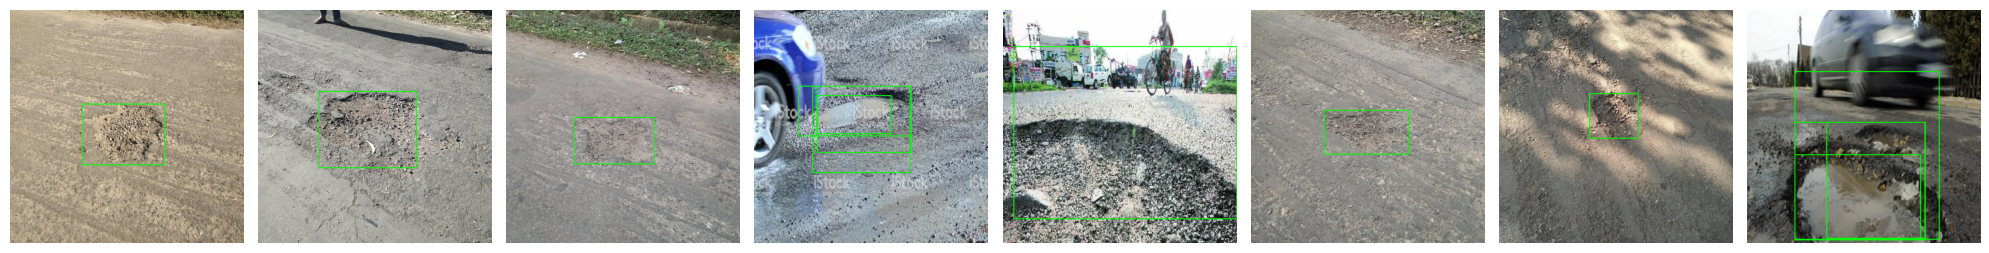

In [224]:
from torch.utils.data import DataLoader

# Define batch size
batch_size = 8

# Create DataLoaders for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Display the first batch of images
images, targets = next(iter(train_loader))
plot_images(images, targets)

